In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dns.name
import json
from typing import Literal
import os
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from IPython.display import clear_output

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.max_colwidth', None)

### Overlapped domain
Time range of overlapped domains are splitted into two time windows due to the change of tranco list.
1. 2023-05-08 to 2023-08-01
2. 2023-08-02 to 2024-03-31
Please run `scpt_dnssec_overlap.py` before running the following blocks.

In [ ]:
recompute = False

In [17]:
# Read overlapped domain list
df_overlap1 = pd.read_csv("../data/plotting/overlap/overlapdom_part1.csv")
df_overlap2 = pd.read_csv("../data/plotting/overlap/overlapdom_part2.csv")
# read adbit
apex_ad1_ov = pd.read_csv("../data/plotting/overlap/adbit_apex1.csv")
apex_ad2_ov = pd.read_csv("../data/plotting/overlap/adbit_apex2.csv")
www_ad1_ov = pd.read_csv("../data/plotting/overlap/adbit_www1.csv")
www_ad2_ov = pd.read_csv("../data/plotting/overlap/adbit_www2.csv")
#read rrsig
apex_rrsig1_ov = pd.read_csv("../data/plotting/overlap/rrsig_apex1.csv")
apex_rrsig2_ov = pd.read_csv("../data/plotting/overlap/rrsig_apex2.csv")
www_rrsig1_ov = pd.read_csv("../data/plotting/overlap/rrsig_www1.csv")
www_rrsig2_ov = pd.read_csv("../data/plotting/overlap/rrsig_www2.csv")

In [18]:
www_ad_ov = pd.concat([www_ad1_ov, www_ad2_ov], ignore_index=True)
apex_ad_ov = pd.concat([apex_ad1_ov, apex_ad2_ov], ignore_index=True)

apex_rrsig_ov = pd.concat([apex_rrsig1_ov, apex_rrsig2_ov], ignore_index=True)
www_rrsig_ov = pd.concat([www_rrsig1_ov, www_rrsig2_ov], ignore_index=True)


In [19]:
### Merge
if recompute:
    apex_https_ov = pd.read_csv("../data/plotting/overlap/adoption_httpsrr_apex.csv")
    apex_admerge_ov = apex_ad_ov.merge(apex_https_ov, on='date', how='inner')
    
    www_https_ov = pd.read_csv("../data/plotting/overlap/adoption_httpsrr_www.csv")
    www_admerge_ov = www_ad_ov.merge(www_https_ov, on='date', how='inner')
    
    www_admerge_ov['adbit_perc'] = www_admerge_ov.apply(lambda x: 100 * x['num_adbit'] / x['num_httpsrr'], axis=1)
    apex_admerge_ov['adbit_perc'] = apex_admerge_ov.apply(lambda x: 100 * x['num_adbit'] / x['num_httpsrr'], axis=1)
    
    apex_rrsig_ov['rrsig_perc'] = apex_rrsig_ov.apply(lambda x: 100 * x['num_rrsig'] / x['num_httpsrr'], axis=1)
    www_rrsig_ov['rrsig_perc'] = www_rrsig_ov.apply(lambda x: 100 * x['num_rrsig'] / x['num_httpsrr'], axis=1)
    
    apex_admerge_ov.to_csv("../data/plotting/overlap/adbit_apex_merge.csv", index=False)
    www_admerge_ov.to_csv("../data/plotting/overlap/adbit_www_merge.csv", index=False)
        
    apex_rrsig_ov.to_csv("../data/plotting/overlap/rrsig_apex_merge.csv", index=False)
    www_rrsig_ov.to_csv("../data/plotting/overlap/rrsig_www_merge.csv", index=False)
else:
    apex_admerge_ov = pd.read_csv("../data/plotting/overlap/adbit_apex_merge.csv")
    www_admerge_ov = pd.read_csv("../data/plotting/overlap/adbit_www_merge.csv")
    apex_rrsig_ov = pd.read_csv("../data/plotting/overlap/rrsig_apex_merge.csv")
    www_rrsig_ov = pd.read_csv("../data/plotting/overlap/rrsig_www_merge.csv")

In [20]:
apex_admerge_ov['datetime'] = apex_admerge_ov['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
www_admerge_ov['datetime'] = www_admerge_ov['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
apex_rrsig_ov['datetime'] = apex_rrsig_ov['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
www_rrsig_ov['datetime'] = www_rrsig_ov['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

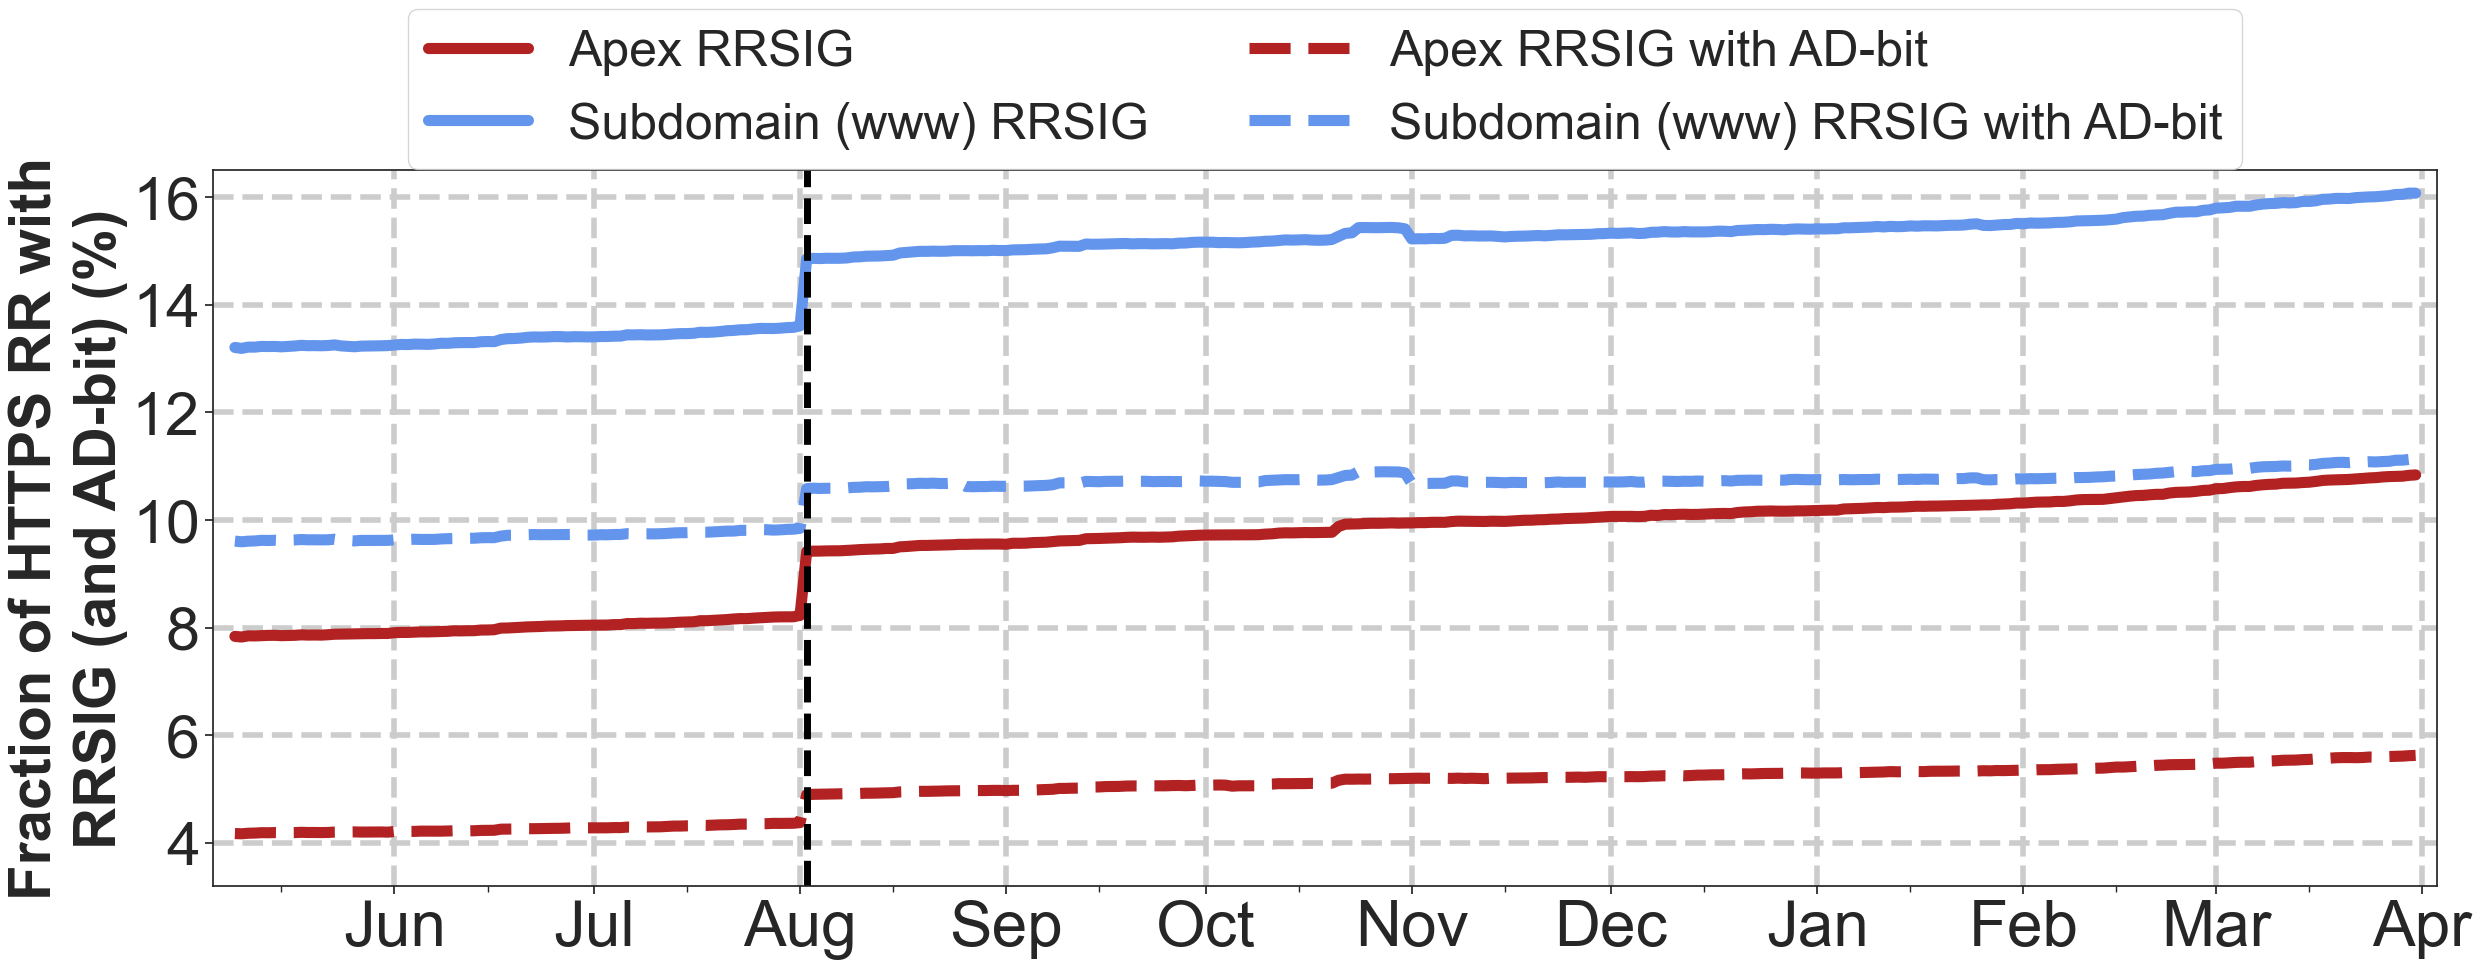

In [21]:
fig = plt.figure(figsize=(25,10))
sns.set(style="ticks")
ax = sns.lineplot(data=apex_rrsig_ov, x="datetime", y="rrsig_perc", linewidth=8, \
                   linestyle="solid", color='firebrick', label='Apex RRSIG')
ax2 = sns.lineplot(data=www_rrsig_ov, x="datetime", y="rrsig_perc", linewidth=8, \
                   linestyle="solid", color='cornflowerblue', label='Subdomain (www) RRSIG')
ax3 = sns.lineplot(data=apex_admerge_ov, x="datetime", y="adbit_perc", linewidth=8, \
                   linestyle='dashed', color='firebrick', label='Apex RRSIG with AD-bit')
ax4 = sns.lineplot(data=www_admerge_ov, x="datetime", y="adbit_perc", linewidth=8, color='cornflowerblue', \
                   linestyle='dashed', label='Subdomain (www) RRSIG with AD-bit')
ax.grid(True, linestyle='--', linewidth=4)


ax.axvline(x=datetime.strptime("2023-08-02", "%Y-%m-%d"), color="black", linestyle="dashed", linewidth=5)
#ax.axvline(x="Oct-06", color="black", linestyle="-.", linewidth=5)

#ax.set_xlim(-0.05, 1.05)
ax.set_ylim(3.2, 16.5)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlabel('')

ax.tick_params(axis='x')
plt.xticks(fontsize=46)
plt.yticks(fontsize=44)
plt.ylabel("Fraction of HTTPS RR with\nRRSIG (and AD-bit) (%)", fontsize=42, labelpad=3, fontweight='bold')
plt.margins(x=.01)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.26), ncol=2, fancybox=True, shadow=False, fontsize=36)
fig.tight_layout()
#fig.savefig('../figures/overlapdom_rrsigadbit.png', dpi=200)
plt.show()